--------------------------------------------------------------------------------------------------------------------------------------------

#### Project Premises

Tasked with the analysis of the investment patterns of one of our major competitors: Fairholme Capital, managed by Bruce Berkowitz. 

DBBA Capital wants you to evaluate the investment patterns of Fairholme Capital in relation to other superinvestors and evaluate the change in investment patterns during the pandemic. They have provided you with data about different superinvestors and the companies they invested in for each quarter spanning from quarter 1 (Q1) of 2019 to quarter 2 (Q2) of 2023 (that you can find in the folder named "Assignment Data"). 

The first column of each file represents the investors and the remaining columns represent the companies each investor invested in. First, familiarlise yourself with the data, and then, follow the steps bellow to perform the necessary analysis.


In the field below, load the first Excel dataset ("2019_Q1.xlsx") and create a network out of the investors and companies in the following manner:

- the nodes of the network are all the investors in the first column of the dataset
- two investors (nodes) are connected with an edge if the have invested in the same company (e.g. Christopher Bloomstran - Semper Augustus and David Abrams - Abrams Capital Management will be connected because they both invested in GOOGL). 
- if two investors have invested in more than one common comapny, do *not* assign multiple edges between them. Instead, assign the number of common companies they have invested in as a weight to the edge connecting them.

After you built the network, extract the largest connected component and plot it. Remember to add the edge weights in your plot.

In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Data: Investor and Company mappings
def build_network(data):
    df = pd.read_excel(data,header= None)

    data = {}  # Dictionary to store investment mappings
    for index, row in df.iterrows():
        investor = row.iloc[0]
        companies = [company.strip() for company in row[1:] if pd.notnull(company)]  
        data[investor] = companies

    # Create an empty graph
    G = nx.Graph()

    # Add nodes (investors) to the graph
    for investor in data.keys():
        G.add_node(investor)

    # Add edges based on common investments and their weights
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            investor1 = list(data.keys())[i]
            investor2 = list(data.keys())[j]
            common_investments = set(data[investor1]) & set(data[investor2])
            if common_investments:
                weight = len(common_investments)
                G.add_edge(investor1, investor2, weight=weight)
    return G


In [10]:
NW=build_network('CW1_DATA/2019_Q1.xlsx')

degree_sequence = dict(NW.degree())
largest_degree_node, largest_degree_value = max(degree_sequence.items(), key=lambda x: x[1])
total_strength = dict(NW.degree(weight='weight'))
largest_strength_node, largest_strength_value = max(total_strength.items(), key=lambda x: x[1])
print (largest_degree_node, largest_degree_value)
print (largest_strength_node, largest_strength_value)
print (NW.degree('Bruce Berkowitz - Fairholme Capital'),NW.degree('Bruce Berkowitz - Fairholme Capital',weight='weight'))


Wallace Weitz - Weitz Value Fund 50
Wallace Weitz - Weitz Value Fund 137
11 11


True


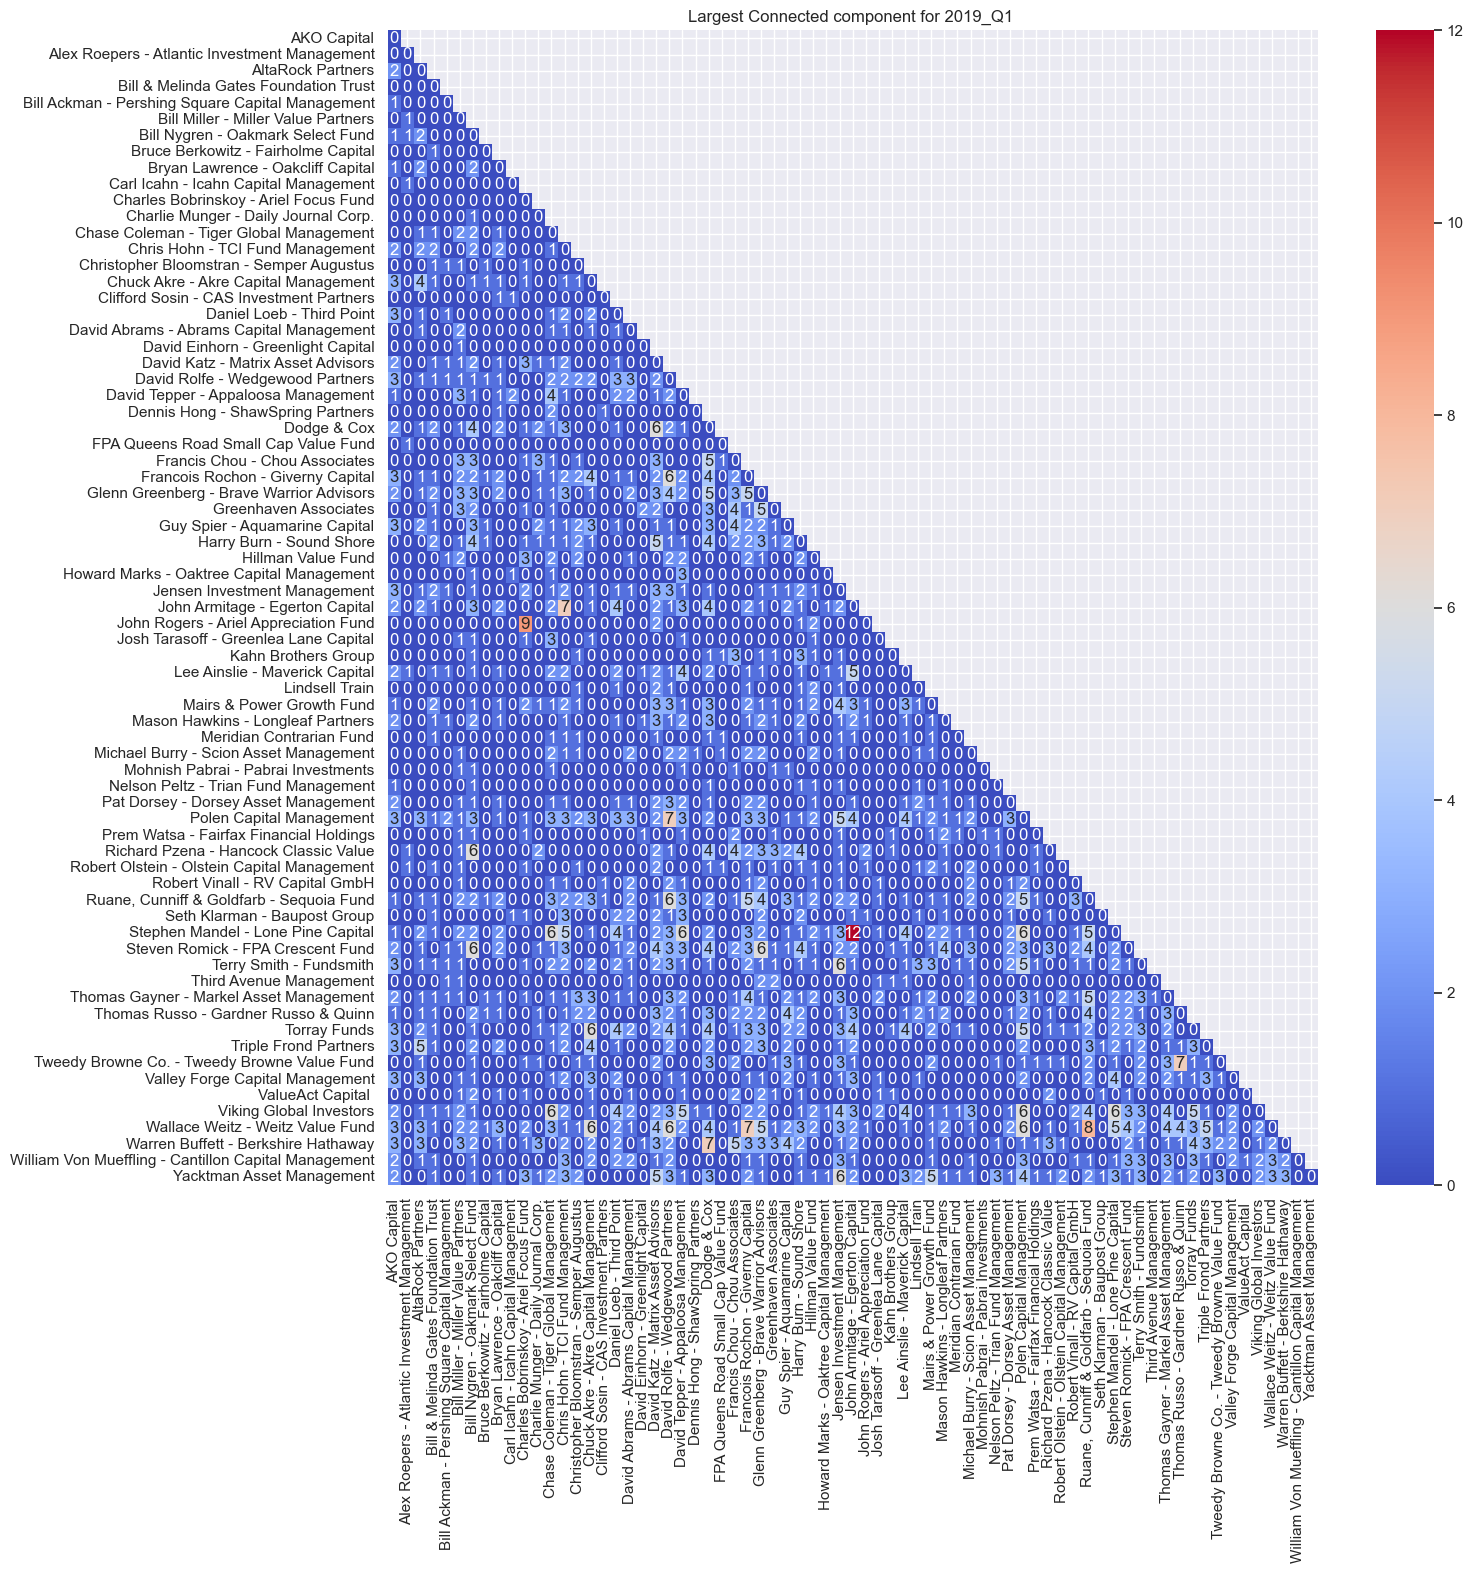

In [9]:
import seaborn as sns
import numpy as np

print (nx.is_connected(NW))
largest_cc = max(nx.connected_components(NW), key=len)
G= NW.subgraph(largest_cc)


# Create an empty correlation matrix
n_nodes = len(G.nodes)
correlation_matrix = np.zeros((n_nodes, n_nodes))

# Fill the correlation matrix with edge weights
for i, node1 in enumerate(G.nodes):
    for j, node2 in enumerate(G.nodes):
        if i >= j:
            # Get the edge weight or set to 0 if no edge
            if G.has_edge(node1, node2):
                correlation_matrix[i][j] = G[node1][node2]["weight"]
            else:
                correlation_matrix[i][j] = 0
        #else:
            #Use symmetry for the lower triangular part of the matrix
            #correlation_matrix[i][j] = correlation_matrix[j][i]
mask = np.triu(np.ones_like(correlation_matrix), k=1) 
# Create a correlogram using Seaborn
sns.set(font_scale=1)
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, xticklabels=G.nodes, yticklabels=G.nodes, cmap="coolwarm",mask=mask)

plt.title("Largest Connected component for 2019_Q1 ")
plt.savefig("Task1_1.png", dpi=300, bbox_inches="tight")
plt.show()

**Task 1.2 (3 marks)** <br>
Obtain the ego-network of 'Bruce Berkowitz - Fairholme Capital' and plot it.

In [11]:
#Function for plotting EGO Graph
def plot_egonetwork(ego_G):
    # Arrange nodes in a circular layout
    positions = nx.circular_layout(ego_G)

    # Define edge colors and weights for the ego node
    edge_colors = []
    edge_weights = []
    edge_label={}

    for edge in ego_G.edges():
        u, v = edge
        if u == ego_node or v == ego_node:
            edge_colors.append('violet')
            edge_weights.append(ego_G[edge[0]][edge[1]]['weight'])
            i=(u,v)
            edge_label[i]=ego_G[u][v]['weight']
            print ()

        else:
            edge_colors.append('lightgray')
    node_colors = ['violet' if node == ego_node else 'lightblue' for node in ego_G.nodes()]

    # Plot the graph with customized edge colors and edge weights as labels
    plt.figure(figsize=(10, 5))

    # Draw edges with labels (weights)
    nx.draw(ego_G, pos=positions, with_labels=True, node_color=node_colors, node_size=800, font_size=8, font_weight='bold', edge_color=edge_colors, width=2)
    nx.draw_networkx_edge_labels(ego_G , pos=positions, edge_labels=edge_label)

    plt.title('Ego Network for ' + str(ego_node))
    plt.savefig("Task1_2.png", dpi=300, bbox_inches="tight")
    plt.show()


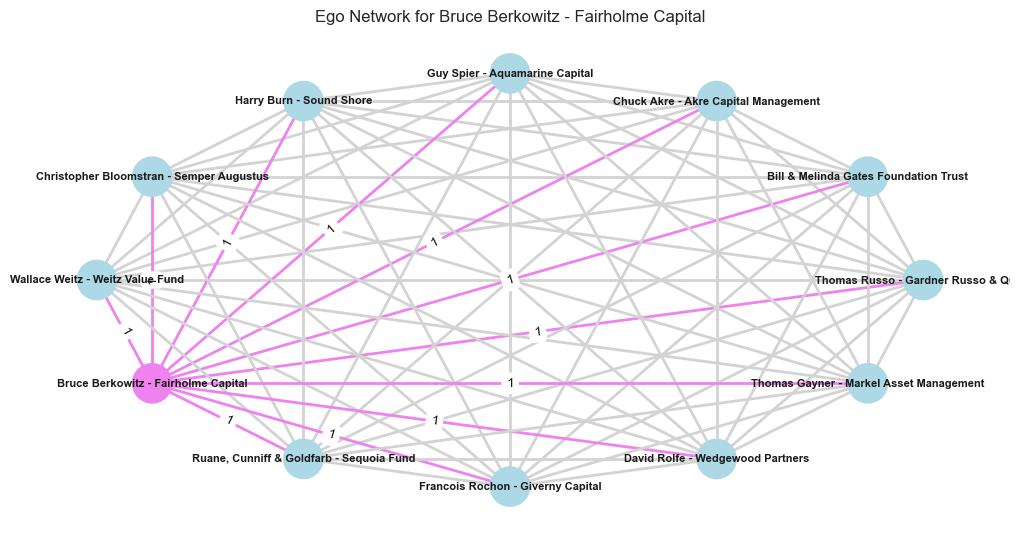

In [12]:
ego_node='Bruce Berkowitz - Fairholme Capital'
ego_NW = nx.ego_graph(NW, ego_node,radius=1)
plot_egonetwork(ego_NW)

#### Part 2: Basic Network Analysis


Now that you know how to build the network for a single quarter and get its largest connected component, repeat the procedure for all the other quarters. For both the whole network and the ego-network, produce a table with the summary statistics (i.e. mean, max, min, and standard deviation) of the following network quantities:

- Number of nodes
- Number of links
- Density
- Average clustering coefficient
- Average degrees
- Average strength
- Assortativity

If you need to make any assumption or decision regarding the metric to use to compute any of these quantities, clearly motivate it.

In [21]:
import os
import glob
import pandas as pd
import networkx as nx
import numpy as np
#import warnings

statistics_list = []
whole_network_statisticslist =[]
ego_network_statisticslist=[]

# Function to compute network statistics
def compute_network_statistics(G):
    num_nodes = len(G.nodes())
    num_links = len(G.edges())
    density = nx.density(G)
    avg_clustering_coefficient = nx.average_clustering(G)
    avg_degree = np.mean([val for (node, val) in G.degree()])
    avg_strength = np.mean([val for (node, val) in G.degree(weight='weight')])
    assortativity = nx.degree_pearson_correlation_coefficient(G, weight='weight')
    
    return {
        'Number of nodes': num_nodes,
        'Number of links': num_links,
        'Density': density,
        'Avg clustering co': avg_clustering_coefficient,
        'Avg degree': avg_degree,
        'Avg strength': avg_strength,
        'Assortativity': assortativity
    }

# Create an empty DataFrame to store statistics
statistics_df = pd.DataFrame(columns=['Quarter', 'Network', 'Metric', 'Value'])

# Path to the folder containing the .xlsx files
folder_path = 'CW1_DATA'

# Get a list of all .xlsx files in the folder
xlsx_files = glob.glob(os.path.join(folder_path, '*.xlsx'))

# Process each .xlsx file
for sheet_name in xlsx_files:
   
    # Build the network for the entire quarter
    whole_network  = build_network(sheet_name)
    
    #with warnings.catch_warnings():
        #warnings.simplefilter("ignore")
    whole_network_statistics = compute_network_statistics(whole_network)
    # Build the ego network for node B
    ego_network_B = nx.ego_graph(whole_network, 'Bruce Berkowitz - Fairholme Capital')
    
    # Compute statistics for the ego network of node B
    #with warnings.catch_warnings():
        #warnings.simplefilter("ignore")
    ego_network_B_statistics = compute_network_statistics(ego_network_B)
    
    whole_network_statisticslist.extend([
        {'Quarter': sheet_name.split("/")[-1].split(".xlsx")[0], 'Network': 'WholeN', 'Metric': metric, 'Value': value}
        for metric, value in whole_network_statistics.items()
    ])
    
    ego_network_statisticslist.extend([
        {'Quarter': sheet_name.split("/")[-1].split(".xlsx")[0], 'Network': 'EgoNW', 'Metric': metric, 'Value': value}
        for metric, value in ego_network_B_statistics.items()
    ])


# Convert the list of dictionaries to a DataFrame
whole_network_statistics_df = pd.DataFrame(whole_network_statisticslist)
ego_network_statistics_df = pd.DataFrame(ego_network_statisticslist)
statistics_df=pd.concat([whole_network_statistics_df, ego_network_statistics_df], ignore_index=False)

In [22]:
def Summary_stats(dataframe):
    summary_statistics = dataframe.groupby(['Network', 'Metric'])['Value'].agg(['mean', 'max', 'min', 'std']).reset_index()

    table_with_edges = summary_statistics.pivot_table(index='Metric', columns=['Network'], values=['mean', 'max', 'min', 'std'])

    # Flatten the MultiIndex columns
    table_with_edges.columns = ['-'.join(col).strip() for col in table_with_edges.columns.values]

    # Rename the columns to include 'mean', 'max', 'min', 'std'

    table_with_edges.columns = ['max', 'mean', 'min', 'std']
    table_name = 'Network'
    table_with_edges = table_with_edges.sort_index(ascending=False)
    styled_table = table_with_edges.to_string(header=True, index=True)
    styled_table = styled_table.replace('\n', '\n' + '-'*len(styled_table.split('\n', 1)[0]) + '\n')
    return styled_table

In [23]:
print(Summary_stats(whole_network_statistics_df))

                           max         mean          min         std
--------------------------------------------------------------------
Metric                                                              
--------------------------------------------------------------------
Number of nodes      77.000000    76.055556    71.000000    1.893401
--------------------------------------------------------------------
Number of links    1383.000000  1281.833333  1064.000000  110.554884
--------------------------------------------------------------------
Density               0.472659     0.448320     0.393928    0.023896
--------------------------------------------------------------------
Avg strength         73.662338    65.860917    53.351351    6.257193
--------------------------------------------------------------------
Avg degree           35.922078    33.668796    28.756757    2.291754
--------------------------------------------------------------------
Avg clustering co     0.717500    

In [24]:
print(Summary_stats(ego_network_statistics_df))

                          max        mean        min         std
----------------------------------------------------------------
Metric                                                          
----------------------------------------------------------------
Number of nodes     38.000000   27.777778  12.000000    9.181539
----------------------------------------------------------------
Number of links    439.000000  287.388889  66.000000  137.192496
----------------------------------------------------------------
Density              1.000000    0.764613   0.603129    0.133240
----------------------------------------------------------------
Avg strength        50.689655   40.846762  26.333333    6.933676
----------------------------------------------------------------
Avg degree          23.729730   19.358005  11.000000    4.370096
----------------------------------------------------------------
Avg clustering co    1.000000    0.856062   0.755714    0.085626
-------------------------

#### Part 3: Comparing Degree Distributions


Choose a single temporal slice (i.e. quarter) and plot and analyse the total degree and strength distributions of both the whole network and the ego-network. Comment on the similarities/differences between these networks. 

In [83]:
def plot_degreeandstrength_dist(G):

    ego_network = nx.ego_graph(G, 'Bruce Berkowitz - Fairholme Capital')
    degrees_whole = dict(G.degree())
    strengths_whole = dict(G.degree(weight='weight'))
    degrees_ego = dict(ego_network.degree())
    strengths_ego = dict(ego_network.degree(weight='weight'))

    # Plot degree distributions
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    plt.hist(list(degrees_whole.values()), bins=20, alpha=0.5, color='b', label='Whole Network')
    plt.hist(list(degrees_ego.values()), bins=20, alpha=0.5, color='r', label='Ego-Network')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title('Degree Distribution (Whole Network vs. Ego-Network)')
    plt.legend()

    # Plot strength distributions
    plt.subplot(2, 2, 2)
    plt.hist(list(strengths_whole.values()), bins=20, alpha=0.5, color='b', label='Whole Network')
    plt.hist(list(strengths_ego.values()), bins=20, alpha=0.5, color='r', label='Ego-Network')
    plt.xlabel('Strength')
    plt.ylabel('Frequency')
    plt.title('Strength Distribution (Whole Network vs. Ego-Network)')
    plt.legend()
    plt.tight_layout()
    plt.savefig("Task3.1.1.png", dpi=300, bbox_inches="tight")
    plt.show()
    


    # Plot degree distributions in log-log scale
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    degree_values_whole = np.array(list(degrees_whole.values()))
    degree_values_ego = np.array(list(degrees_ego.values()))
    plt.loglog(degree_values_whole, 'bo', label='Whole Network', markersize=3)
    plt.loglog(degree_values_ego, 'ro', label='Ego-Network', markersize=3)
    plt.xlabel('Degree (log scale)')
    plt.ylabel('Frequency (log scale)')
    plt.title('Degree Distribution (Whole Network vs. Ego-Network) in Log-Log Scale')
    plt.legend()

    # Plot strength distributions in log-log scale
    plt.subplot(2, 2, 2)
    strength_values_whole = list(strengths_whole.values())
    strength_values_ego = list(strengths_ego.values())
    plt.loglog(strength_values_whole, 'bo', label='Whole Network', markersize=3)
    plt.loglog(strength_values_ego, 'ro', label='Ego-Network', markersize=3)
    plt.xlabel('Strength (log scale)')
    plt.ylabel('Frequency (log scale)')
    plt.title('Strength Distribution (Whole Network vs. Ego-Network) in Log-Log Scale')
    plt.legend()
    plt.tight_layout()
    plt.savefig("Task3.1.2.png", dpi=300, bbox_inches="tight")
    plt.show()


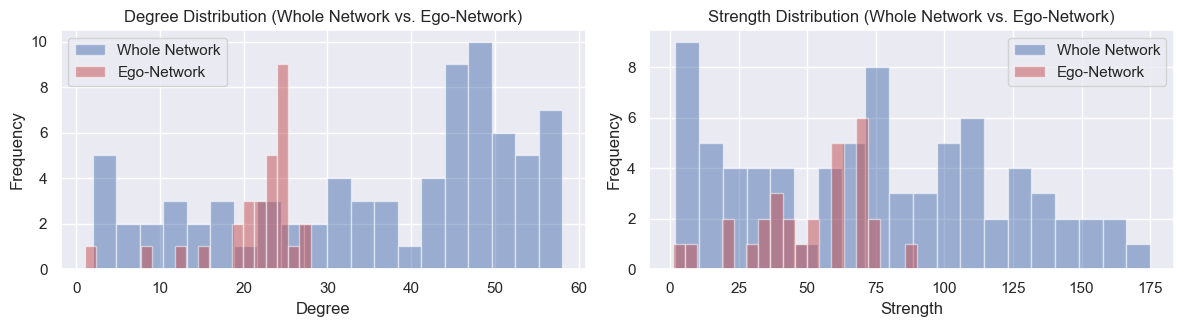

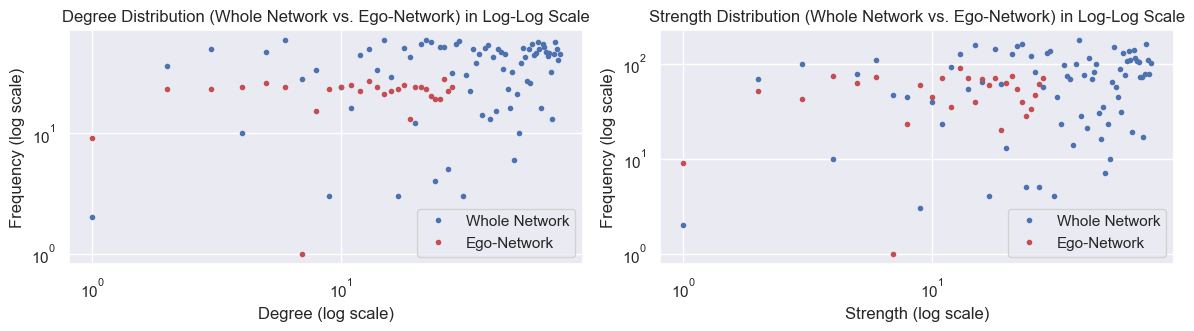

In [84]:
Q7=build_network('CW1_DATA/2020_Q3.xlsx')
plot_degreeandstrength_dist(Q7)


Based on degree distributions and the results you obtained, what type of network would you say the whole network and ego-network are (e.g scale free, random, etc)? Could have they been generated by any of the models discussed in class? Motivate your answer.

In [87]:
import random
def watts_strogatz_graph(N, k, p):
    # 1. Create a ring of N nodes
    G = nx.cycle_graph(N)

    # 2. Connect each node n to k nearest neighbors
    #    [n-(k//2), ... , n-1, n+1, ... , n+(k//2)]
    for n in G.nodes:
        for i in range(1, k // 2 + 1):
            left  = (n-i) % N
            right = (n+i) % N 
            G.add_edge(n, left)
            G.add_edge(n, right)
    
    # 3. Rewire edges with probability p
    for u, v in list(G.edges):
        if random.random() < p:
            not_neighbors = set(G.nodes) - set(G.neighbors(u)) - {u}
            w = random.choice(list(not_neighbors))
            G.remove_edge(u, v)
            G.add_edge(u, w)

    return G

In [88]:
SW = watts_strogatz_graph(77, 36, 0.05)

In [89]:
print(nx.average_clustering(SW))
print(nx.average_clustering(Q7))
print(nx.average_shortest_path_length(SW))
print(nx.average_shortest_path_length(Q7))
print(np.mean([val for (node, val) in SW.degree()]))
print(np.mean([val for (node, val) in Q7.degree()]))

0.6649969951413303
0.7117226587222614
1.527341079972659
1.582365003417635
36.0
35.922077922077925


In [113]:
EGOSW=watts_strogatz_graph(29, 22, 0.02)
EGO_Q7=nx.ego_graph(Q7, 'Bruce Berkowitz - Fairholme Capital')

In [114]:
print(nx.average_clustering(EGOSW))
print(nx.average_clustering(EGO_Q7))
print(nx.average_shortest_path_length(EGOSW))
print(nx.average_shortest_path_length(EGO_Q7))
print(np.mean([val for (node, val) in EGOSW.degree()]))
print(np.mean([val for (node, val) in EGO_Q7.degree()]))

0.7805621112888532
0.8379629532553071
1.2142857142857142
1.2389162561576355
22.0
21.310344827586206


#### Part 4: Changes of the network statistics during the pandemic

Plot the temporal evolution of the quantities you computed in Part 2 for the ego network and the whole network compare the difference between the networks. For each quantity, discuss if it can be used for analysing the investment patterns of Bruce Berkowitz - Fairholme Capital over time. Based on your discussion, choose the quantities that you find important. What information you can draw about the change of those network statistics during the pandemic?

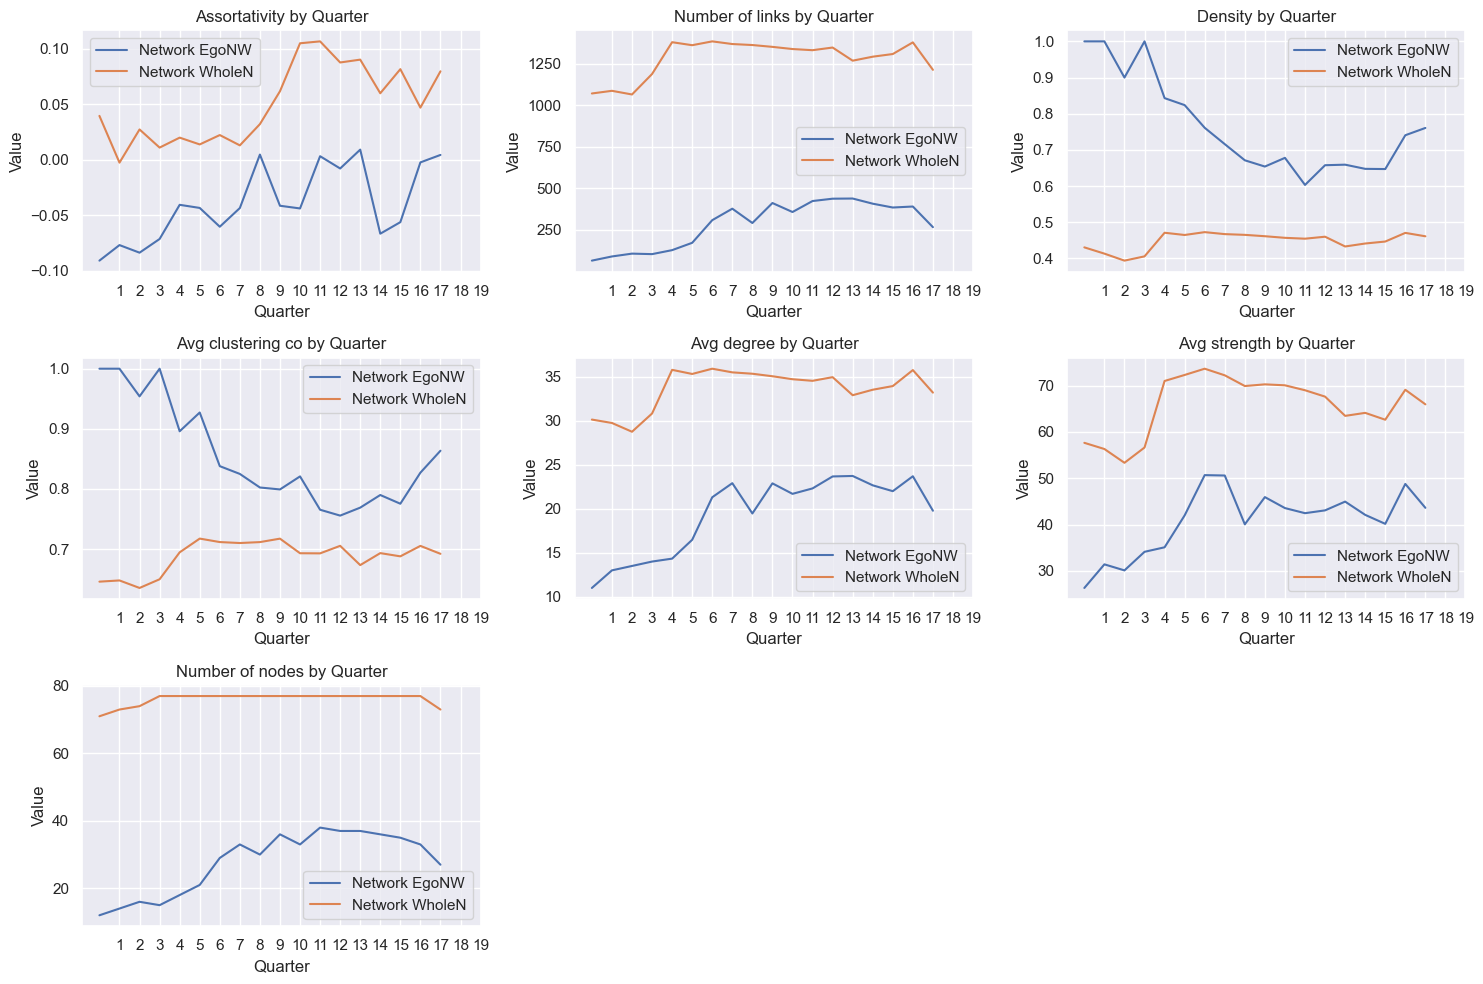

In [207]:

# Sort the DataFrame by 'Quarter' column
sorted_df = statistics_df.sort_values(by='Quarter')
unique_metrics = sorted_df['Metric'].unique()

# The number of rows and columns for subplots
num_rows = 3 
num_cols = 3 

# Create a new figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))


axes = axes.flatten()

# Iterate through the metrics
for i, metric in enumerate(unique_metrics):
    # Select the current subplot
    ax = axes[i]
    
    metric_data = sorted_df[sorted_df['Metric'] == metric]
    
    # Plot the data for the current metric
    for network, network_data in metric_data.groupby('Network'):
        ax.plot(network_data['Quarter'], network_data['Value'], label=f'Network {network}')
    
    ax.set_xlabel('Quarter')
    ax.set_ylabel('Value')
    ax.set_title(f'{metric} by Quarter')
    ax.legend()
    ax.grid(True)
    ax.set_xticks(range(1, 20))
    ax.set_xticklabels(range(1, 20)
                      )
for i in range(7, num_rows * num_cols):
    fig.delaxes(axes[i])
    
plt.savefig("Task4.2.png")
plt.tight_layout()

plt.show()


Choose a suitable centrality measure that would give us imporatnt information about the nodes in the whole network, and clearly motivate your choice. Use this measure to find the 3 most central nodes for each quarter. Compare the centrality of Bruce Berkowitz - Fairholme Capital overtime with that of the most central nodes. What can you conclude from this?

In [223]:

# Directory where Excel files are located
data_folder = 'CW1_DATA'

# Create a dictionary to store results for each quarter
results = {}
top_nodes_list=[]
columns = ['Rank 1', 'Rank 2', 'Rank 3']
top_nodes_df = pd.DataFrame(columns=columns)
for quarter_file in os.listdir(data_folder):
    if quarter_file.endswith('.xlsx'):
        top_nodes1=[]
        quarter = quarter_file.split('.')[0]  # Extract the quarter name
        file_path = os.path.join(data_folder, quarter_file)
        weighted_degree_centrality = {}
        # Build the network from the Excel file
        G = build_network(file_path)

        # Compute Eigen centrality for all nodes
        for node in G.nodes():
            weighted_degree = sum(G[node][neighbor]['weight'] for neighbor in G.neighbors(node))
            weighted_degree_centrality[node] = weighted_degree

        # Find the 3 most central nodes
        top_nodes = sorted(weighted_degree_centrality, key=weighted_degree_centrality.get, reverse=True)[:3]
        
        for top_node in top_nodes:
            
            shortest_path_length = nx.shortest_path_length(G, source=top_node, target='Bruce Berkowitz - Fairholme Capital')
            top_nodes1.append(f"{top_node}-{shortest_path_length}")
        
        results[quarter] = {
            'weighted_degree_centrality': weighted_degree_centrality,
            'top_nodes': ', '.join(top_nodes)
        }
        sorted_results = {quarter: results[quarter] for quarter in sorted(results.keys())}

        top_nodes_list.append({
            'Quarter': quarter,
            'Top Nodes': ', '.join(top_nodes1)  # Convert top nodes to a comma-separated string
        })
        


In [224]:

# Convert the list of dictionaries to a pandas DataFrame
top_nodes_df = pd.DataFrame(top_nodes_list)

# Set the 'Quarter' column as the index
top_nodes_df.set_index('Quarter', inplace=True)

# Split the 'Top Nodes' column into separate columns
top_nodes_df = top_nodes_df['Top Nodes'].str.split(', ', expand=True)

top_nodes_df = top_nodes_df.sort_index()

top_nodes_df

,0,1,2
Quarter,,,
2019_Q1,Wallace Weitz - Weitz Value Fund-1,Polen Capital Management-2,Stephen Mandel - Lone Pine Capital-2
2019_Q2,Wallace Weitz - Weitz Value Fund-1,Polen Capital Management-2,Glenn Greenberg - Brave Warrior Advisors-1
2019_Q3,Wallace Weitz - Weitz Value Fund-1,Polen Capital Management-2,Steven Romick - FPA Crescent Fund-2
2019_Q4,Christopher Davis - Davis Advisors-1,Wallace Weitz - Weitz Value Fund-1,Steven Romick - FPA Crescent Fund-2
2020_Q1,Christopher Davis - Davis Advisors-1,Wallace Weitz - Weitz Value Fund-1,John Armitage - Egerton Capital-2
2020_Q2,Wallace Weitz - Weitz Value Fund-1,David Tepper - Appaloosa Management-2,Christopher Davis - Davis Advisors-1
2020_Q3,John Armitage - Egerton Capital-2,David Tepper - Appaloosa Management-1,Wallace Weitz - Weitz Value Fund-1
2020_Q4,David Tepper - Appaloosa Management-1,Christopher Davis - Davis Advisors-1,John Armitage - Egerton Capital-2
2021_Q1,Polen Capital Management-2,Christopher Davis - Davis Advisors-1,John Armitage - Egerton Capital-2


In [221]:
target_node = 'Bruce Berkowitz - Fairholme Capital'  # Replace 'N' with the node of interest

for quarter, quarter_results in sorted_results.items():
    eigen_centrality = quarter_results['weighted_degree_centrality']

    if target_node in eigen_centrality:
        centrality_value = eigen_centrality[target_node]
        sorted_nodes = sorted(eigen_centrality, key=eigen_centrality.get, reverse=True)
        centrality_rank = sorted_nodes.index(target_node) + 1
        #print(f'Quarter: {quarter}')
        print(f'Quarter: {quarter} Centrality Rank: {centrality_rank} Centrality: {centrality_value}')
        #print(f'Node {target_node} Centrality Rank: {centrality_rank}')
    else:
        print(f'Node {target_node} not found in quarter {quarter}')


Quarter: 2019_Q1 Centrality Rank: 63 Centrality: 11
Quarter: 2019_Q2 Centrality Rank: 62 Centrality: 13
Quarter: 2019_Q3 Centrality Rank: 62 Centrality: 15
Quarter: 2019_Q4 Centrality Rank: 63 Centrality: 14
Quarter: 2020_Q1 Centrality Rank: 64 Centrality: 18
Quarter: 2020_Q2 Centrality Rank: 58 Centrality: 27
Quarter: 2020_Q3 Centrality Rank: 51 Centrality: 47
Quarter: 2020_Q4 Centrality Rank: 49 Centrality: 53
Quarter: 2021_Q1 Centrality Rank: 52 Centrality: 41
Quarter: 2021_Q2 Centrality Rank: 48 Centrality: 49
Quarter: 2021_Q3 Centrality Rank: 48 Centrality: 47
Quarter: 2021_Q4 Centrality Rank: 46 Centrality: 55
Quarter: 2022_Q1 Centrality Rank: 48 Centrality: 54
Quarter: 2022_Q2 Centrality Rank: 42 Centrality: 56
Quarter: 2022_Q3 Centrality Rank: 41 Centrality: 54
Quarter: 2022_Q4 Centrality Rank: 48 Centrality: 49
Quarter: 2023_Q1 Centrality Rank: 51 Centrality: 45
Quarter: 2023_Q2 Centrality Rank: 48 Centrality: 38


#### Part 5: Clustering and Modularity

Find the communities in each quarter in the whole network. To do so, use an algorithm of your choice, and justify your decision. Analyse how the communities evolve overtime, focussing on the membership of Bruce Berkowitz - Fairholme Capital. Does this node fall in the same community with the same superinvestors across different quarters? What conclusions can you draw from this?

In [322]:
import community
data_folder = 'CW1_DATA'

# Define node N
node_N = "Bruce Berkowitz - Fairholme Capital"  # Replace with the actual node ID

# Create dictionaries to store community results, largest community info, and largest degree node
community_results = {}
largest_community_info = {}
largest_degree_node_info = {}
community_information={}

# Iterate through the 18 quarters
for quarter_file in os.listdir(data_folder):
    if quarter_file.endswith('.xlsx'):
        quarter = quarter_file.split('.')[0]  # Extract the quarter name
        file_path = os.path.join(data_folder, quarter_file)
        weighted_degree_centrality = {}
        # Build the network from the Excel file
        network = build_network(file_path)
        community_info=[]
    # Perform community detection using the Louvain method
    partition = community.best_partition(network)
    community_info.append(len(set(partition.values())))
    community_results[quarter] = partition

    community_sizes = {}
    for node, community_id in partition.items():
        if community_id not in community_sizes:
            community_sizes[community_id] = 0
        community_sizes[community_id] += 1
    modularity = community.modularity(partition, network) 
    print (modularity) 
# Sort communities by size in descending order
    sorted_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)

    if node_N in partition:
        
        community_N = partition[node_N]
        community_rank = sorted_communities.index(community_N) + 1 
        #print (nodes_in_community_N)
        community_info.append(community_rank)
        nodes_in_community_N= [node for node, community_id in partition.items() if community_id == community_N]
        community_info.append(len(nodes_in_community_N))
        
        largest_degree_node = max(
            (node for node in network.nodes() if partition[node] == community_N),
            key=lambda x: network.degree[x],
            default=None  # Return None if N is the only node in the community
        )
        community_info.append(largest_degree_node)
        
    else:
        #largest_community_info[quarter] = "Node N is not in any community."
        community_info.append(largest_degree_node)
        #largest_degree_node_info[quarter] = None
    community_information[quarter]=community_info


0.1393487854447417
0.13872842415187153
0.13776091726851558
0.1573318626601652
0.13636400371209573
0.15635526220005508
0.1645594527623801
0.12727146361519187
0.1558622996439774
0.14417480245830916
0.14420197363662907
0.14230234237295333
0.1906034784518908
0.1798640971097216
0.13423260900665324
0.14099712648119245
0.14064907269213867
0.18439627301014283


In [310]:
community_info_df = pd.DataFrame.from_dict(community_information, orient='index', columns=['Num_Partitions', 'Community_Rank', 'Num_Nodes_In_Community', 'Largest_Degree_Node'])
community_info_df = community_info_df.sort_index()
community_info_df

,Num_Partitions,Community_Rank,Num_Nodes_In_Community,Largest_Degree_Node
2019_Q1,4,3,16,Wallace Weitz - Weitz Value Fund
2019_Q2,4,3,21,Wallace Weitz - Weitz Value Fund
2019_Q3,4,3,13,Wallace Weitz - Weitz Value Fund
2019_Q4,3,3,15,Christopher Davis - Davis Advisors
2020_Q1,4,1,23,Steven Romick - FPA Crescent Fund
2020_Q2,4,3,17,Christopher Davis - Davis Advisors
2020_Q3,5,1,29,Christopher Davis - Davis Advisors
2020_Q4,3,3,15,Christopher Davis - Davis Advisors
2021_Q1,4,3,17,Christopher Davis - Davis Advisors
2021_Q2,4,3,18,Christopher Davis - Davis Advisors


#### Part 6: Report your findings

</br> As any good DBBA Capital data analyst, at the end of your analysis you need to present your fidnings. Please write a brief (~250 words) report discussing how the portfolio of Fairholme Capital has changed compared with the rest of the funds in the dataset.

**REPORT**


In [ ]:
import os
import pandas as pd

# Directory containing Excel files
directory_path = 'CW1_DATA'  # Replace with your directory path

# Initialize an empty dictionary to store the results
result_dict = {}

# Iterate through each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.xlsx'): 
        file_path = os.path.join(directory_path, filename)
        xls = pd.ExcelFile(file_path)
        
        # Iterate through each sheet in the Excel file
        for sheet_name in xls.sheet_names:
            df = pd.read_excel(file_path, sheet_name=sheet_name)
            
            # Check if the target value is in the first column of the DataFrame and ignore NaN values
            mask = (df.iloc[:, 0] == 'Bruce Berkowitz - Fairholme Capital') & (~df.iloc[:, 0].isna())
            
            if mask.any():
                # Get the row that matches the condition
                row_contents = df[mask].values.tolist()[0]
                
                # Remove NaN values from the row_contents
                row_contents = [value for value in row_contents if not pd.isna(value)]

                # Extract the common investors for each company in the row
                common_investors = {}
                for company in row_contents[1:]:
                    # Initialize a count for the current company
                    count = 0
                    # Iterate through each sheet again to find common investors
                    for inner_sheet_name in xls.sheet_names:
                        inner_df = pd.read_excel(file_path, sheet_name=inner_sheet_name)
                        for col in inner_df.columns[1:]:
                            if inner_df.iloc[0, 0] != 'Bruce Berkowitz - Fairholme Capital':
                                # Check if the investor in the current column has invested in the current company
                                if company in inner_df[col].values:
                                    count += 1
                    # Add the count to the common_investors dictionary
                    common_investors[company] = count

                # Append the common investor count to each company in the row
                row_contents[1:] = [f"{company} ({count} common investors)" for company, count in common_investors.items()]

                # Store the row contents in the dictionary with the sheet name and file name as keys
                result_dict[filename] = row_contents

sorted_result_dict = {k: result_dict[k] for k in sorted(result_dict)}



In [328]:

df = pd.DataFrame.from_dict(sorted_result_dict, orient='index')

# Print the DataFrame as a table
df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
2019_Q1.xlsx,Bruce Berkowitz - Fairholme Capital,JOE (1 common investors),BRK.B (5 common investors),VSTO (1 common investors),None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2019_Q2.xlsx,Bruce Berkowitz - Fairholme Capital,JOE (1 common investors),VSTO (1 common investors),BRK.B (7 common investors),None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2019_Q3.xlsx,Bruce Berkowitz - Fairholme Capital,JOE (1 common investors),KHC (3 common investors),BRK.B (8 common investors),VSTO (1 common investors),None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2019_Q4.xlsx,Bruce Berkowitz - Fairholme Capital,JOE (1 common investors),BRK.B (8 common investors),VSTO (1 common investors),None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2020_Q1.xlsx,Bruce Berkowitz - Fairholme Capital,JOE (1 common investors),BRK.B (6 common investors),KHC (4 common investors),OXY (2 common investors),SPG (1 common investors),WES (1 common investors),VSTO (1 common investors),None,None,...,None,None,None,None,None,None,None,None,None,None
2020_Q2.xlsx,Bruce Berkowitz - Fairholme Capital,JOE (1 common investors),BRK.B (7 common investors),KHC (4 common investors),OXY (3 common investors),WES (1 common investors),SPG (2 common investors),BRK.A (6 common investors),None,None,...,None,None,None,None,None,None,None,None,None,None
2020_Q3.xlsx,Bruce Berkowitz - Fairholme Capital,JOE (1 common investors),BRK.B (6 common investors),BAC (9 common investors),KHC (3 common investors),T (3 common investors),CNQ (1 common investors),WES (1 common investors),SPG (1 common investors),KMI (2 common investors),...,AAPL (6 common investors),BRK.A (6 common investors),OXY.WS (2 common investors),None,None,None,None,None,None,None
2020_Q4.xlsx,Bruce Berkowitz - Fairholme Capital,JOE (1 common investors),BAC (8 common investors),BRK.B (7 common investors),CNQ (1 common investors),T (2 common investors),KMI (2 common investors),CINF (1 common investors),ENB (1 common investors),WES (1 common investors),...,ORI (1 common investors),ET (4 common investors),MO (1 common investors),EPD (2 common investors),PAA (2 common investors),MMP (1 common investors),PM (4 common investors),AAPL (7 common investors),BRK.A (5 common investors),OXY.WS (2 common investors)
2021_Q1.xlsx,Bruce Berkowitz - Fairholme Capital,JOE (1 common investors),BRK.B (6 common investors),ENB (1 common investors),T (2 common investors),KMI (2 common investors),CVS (4 common investors),WES (1 common investors),VST (2 common investors),ET (3 common investors),...,ORI (2 common investors),VZ (3 common investors),TRP (1 common investors),AAPL (7 common investors),BRK.A (5 common investors),None,None,None,None,None
2021_Q2.xlsx,Bruce Berkowitz - Fairholme Capital,JOE (1 common investors),CMC (1 common investors),ENB (1 common investors),BRK.B (9 common investors),KMI (2 common investors),ET (3 common investors),WES (1 common investors),VST (2 common investors),INTC (5 common investors),...,ORI (2 common investors),BABA (9 common investors),AAPL (7 common investors),EPD (1 common investors),BRK.A (6 common investors),None,None,None,None,None
